In [1]:
import os
import tensorflow as tf
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
import math

from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, HTML
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
import pandas as pd

from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [4]:
train_data_dir = r'W:/RAFDB/RAFDB/train/'
validation_data_dir = r'W:/RAFDB/RAFDB/val/'

In [5]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
CHANNELS = 3
num_classes = 7

batch_size=32*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)
class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [6]:
# Init the Image Data Generator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Train Images
train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
)

# Validation images (From Train Images)
validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'
)

Found 10733 images belonging to 7 classes.
Found 4606 images belonging to 7 classes.


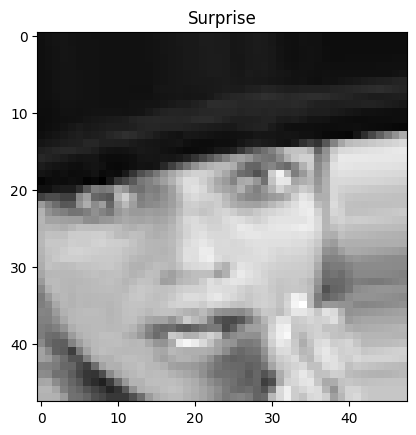

In [7]:
img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [8]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(pd.concat([train_count, test_count], axis=0).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,606,613,248,4169,2242,1722,1133
test,261,264,107,1788,962,738,486


In [9]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

10733
4606


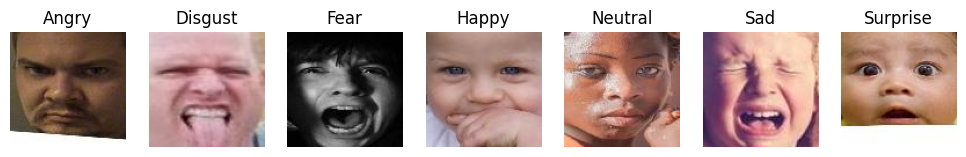

In [10]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_data_dir):
    img_file = random.choice(os.listdir(train_data_dir + expression))
    img = load_img(os.path.join(train_data_dir, expression, img_file))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# PERFECT CODE

In [11]:
import tensorflow as tf

def basic_block(x, in_channels, out_channels, stride=1):
    expansion = 1
    identity = x
    
    x = tf.keras.layers.Conv2D(
        out_channels,
        kernel_size=3,
        strides=stride,
        padding='same',
        use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(
        out_channels,
        kernel_size=3,
        strides=1,
        padding='same',
        use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    if stride != 1 or in_channels != out_channels:
        identity = tf.keras.layers.Conv2D(
            out_channels * expansion,
            kernel_size=1,
            strides=stride,
            use_bias=False)(identity)
        identity = tf.keras.layers.BatchNormalization()(identity)
    
    x = tf.keras.layers.Add()([x, identity])
    x = tf.keras.layers.ReLU()(x)
    
    return x

def make_layer(x, block, out_channels, num_blocks, stride):
    x = block(x, x.shape[-1], out_channels, stride)
    for _ in range(1, num_blocks):
        x = block(x, out_channels, out_channels, 1)
    return x

def ResNet18(input_shape=(48, 48, 3), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        strides=1,
        padding='same',
        use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = make_layer(x, basic_block, 64, 2, 1)
    x = make_layer(x, basic_block, 128, 2, 2)
    x = make_layer(x, basic_block, 256, 2, 2)
    x = make_layer(x, basic_block, 512, 2, 2)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)


# #     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.5)(x)  # Dropout layer for regularization
#     x = Dense(512)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)  # Additional dropout layer

# #     # Add weight regularization to the dense layers
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(128)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

    # # Additional improvements
    x = tf.keras.layers.Dropout(0.2)(x)  # Apply dropout for regularization

    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Increase model capacity
    x = tf.keras.layers.Dropout(0.5)(x)  # Additional dropout
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Creating an instance of ResNet18
model = ResNet18()

# Creating dummy input
dummy_input = tf.random.normal((1, 48, 48, 3))

# Checking the output shape
output = model(dummy_input)
print(output.shape)

(1, 7)


In [12]:
# import tensorflow as tf

# def basic_block(x, in_channels, out_channels, stride=1):
#     expansion = 1
#     identity = x
    
#     x = tf.keras.layers.Conv2D(
#         out_channels,
#         kernel_size=3,
#         strides=stride,
#         padding='same',
#         use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
    
#     x = tf.keras.layers.Conv2D(
#         out_channels,
#         kernel_size=3,
#         strides=1,
#         padding='same',
#         use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     if stride != 1 or in_channels != out_channels:
#         identity = tf.keras.layers.Conv2D(
#             out_channels * expansion,
#             kernel_size=1,
#             strides=stride,
#             use_bias=False)(identity)
#         identity = tf.keras.layers.BatchNormalization()(identity)
    
#     x = tf.keras.layers.Add()([x, identity])
#     x = tf.keras.layers.ReLU()(x)
    
#     return x

# def make_layer(x, block, out_channels, num_blocks, stride):
#     x = block(x, x.shape[-1], out_channels, stride)
#     for _ in range(1, num_blocks):
#         x = block(x, out_channels, out_channels, 1)
#     return x

# def ResNet18(input_shape=(48, 48, 3), num_classes=7):
#     inputs = tf.keras.Input(shape=input_shape)
    
#     x = tf.keras.layers.Conv2D(
#         64,
#         kernel_size=3,
#         strides=1,
#         padding='same',
#         use_bias=False)(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
    
#     x = make_layer(x, basic_block, 64, 2, 1)
#     x = make_layer(x, basic_block, 128, 2, 2)
#     x = make_layer(x, basic_block, 256, 2, 2)
#     x = make_layer(x, basic_block, 512, 2, 2)
    
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)


# # #     x = GlobalAveragePooling2D()(x)
# #     x = Dropout(0.5)(x)  # Dropout layer for regularization
# #     x = Dense(512)(x)
# #     x = BatchNormalization()(x)
# #     x = Activation('relu')(x)
# #     x = Dropout(0.5)(x)  # Additional dropout layer

# # #     # Add weight regularization to the dense layers
# #     x = Dense(256)(x)
# #     x = BatchNormalization()(x)
# #     x = Activation('relu')(x)
# #     x = Dropout(0.5)(x)
# #     x = Dense(128)(x)
# #     x = BatchNormalization()(x)
# #     x = Activation('relu')(x)

#     # # Additional improvements
#     x = tf.keras.layers.Dropout(0.5)(x)  # Apply dropout for regularization
#     x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Increase model capacity

#     # x = tf.keras.layers.Dense(4096, activation='relu')(x)  # Increase model capacity
#     x = tf.keras.layers.Dropout(0.5)(x)  # Additional dropout
    
#     outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model

# # Creating an instance of ResNet18
# model = ResNet18()

# # Creating dummy input
# dummy_input = tf.random.normal((1, 48, 48, 3))

# # Checking the output shape
# output = model(dummy_input)
# print(output.shape)

In [13]:
# Open the strategy scope
with strategy.scope():
    model = ResNet18()
    # Compile the model
    model.compile(optimizer=Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Save the model architecture diagram as a PNG file
# plot_model(model, to_file='resnet18_architecture.png', show_shapes=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 48, 48, 64)   1728        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 48, 48, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_17 (ReLU)                (None, 48, 48, 64)   0           ['batch_normalization_20[0]

In [14]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [92]:
# Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=400,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/400
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = hierarchical_copy, num_packs = 1
167/167 [==============================] - ETA: 0s - loss: 3.7828 - accuracy: 0.2709
Epoch 1: val_accuracy improved from -inf to 0.38776, saving model to best_model.h5
167/167 [==============================] - 27s 113ms/step - loss: 3.7828 - accuracy: 0.2709 - val_loss: 1.6573 - val_accuracy: 0.3878 - lr: 0.0010
Epoch 2/400
167/167 [==============================] - ETA: 0s - loss: 3.4311 - accuracy: 0.3120
Epoch 2: val_accuracy improved from 0.38776 to 0.38842, saving model to best_model.h5
167/167 [==============================] - 17s 99ms/step - loss: 3.4311 - accuracy: 0.3120 - val_loss: 1.6458 - val_accuracy: 0.3884 - lr: 0.0010
Epoch 3/400
167/167 [==============================] - ETA: 0s - loss: 3.4134 - accuracy: 0.3388
Epoch 3: val_accuracy improved from 0.38842 to 0.

In [93]:
save_model = model.save('RESNET18_Ultimate8.h5')

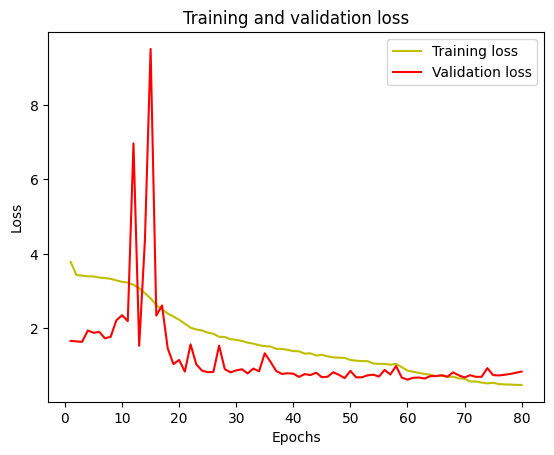

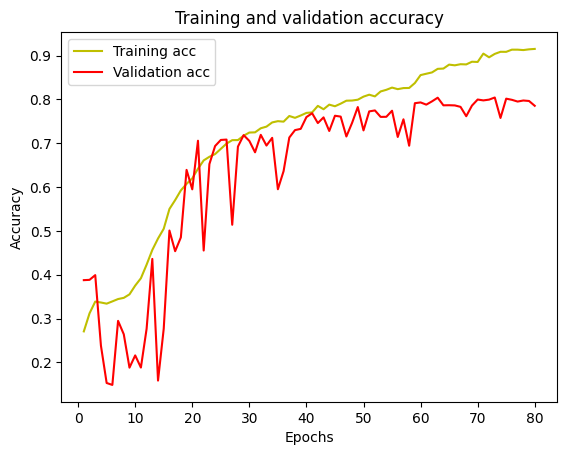

In [94]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = load_model('best_model.h5')
model.summary()

2/2 [==============================] - 2s 111ms/step
Accuracy =  0.796875


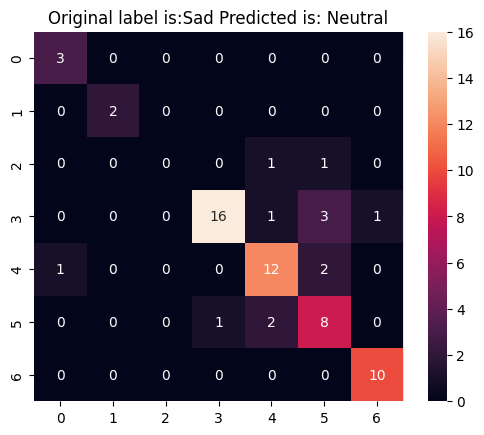

In [95]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Model Evaluation

Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 43ms/step
Accuracy =  0.875


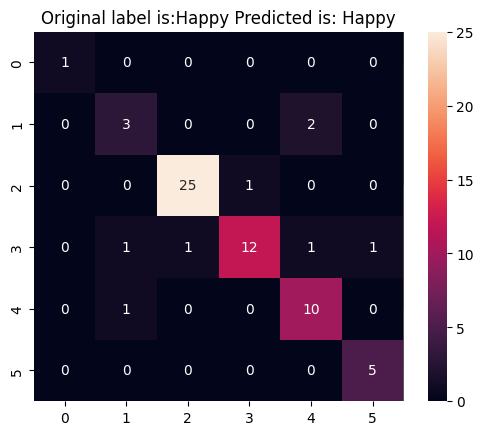

2/2 [==============================] - 0s 43ms/step
Accuracy =  0.65625


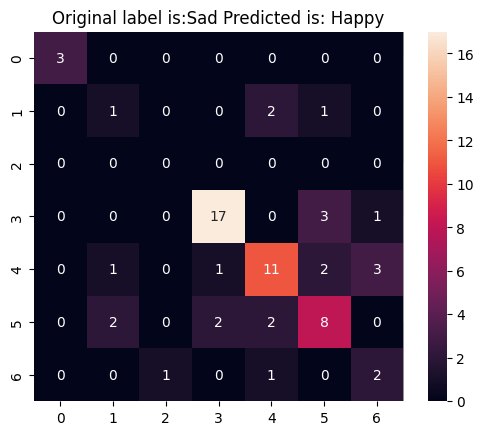

In [96]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [97]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.7850


In [98]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 45ms/step
Accuracy: 78.49911971830986
Angry 261/4606 acc: 75.5
Disgust 262/4606 acc: 45.0
Fear 106/4606 acc: 57.5
Happy 1761/4606 acc: 84.6
Neutral 950/4606 acc: 72.9
Sad 726/4606 acc: 86.1
Surprise 478/4606 acc: 80.1


In [99]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 78.49911971830986
Angry 261/4606 acc: 75.5
Disgust 262/4606 acc: 45.0
Fear 106/4606 acc: 57.5
Happy 1761/4606 acc: 84.6
Neutral 950/4606 acc: 72.9
Sad 726/4606 acc: 86.1
Surprise 478/4606 acc: 80.1


              precision    recall  f1-score   support

       Angry       0.65      0.75      0.70       261
     Disgust       0.52      0.45      0.48       262
        Fear       0.49      0.58      0.53       106
       Happy       0.97      0.85      0.90      1761
     Neutral       0.75      0.73      0.74       950
         Sad       0.65      0.86      0.74       726
    Surprise       0.81      0.80      0.81       478

    accuracy                           0.78      4544
   macro avg       0.69      0.72      0.70      4544
weighted avg       0.80      0.78      0.79      4544



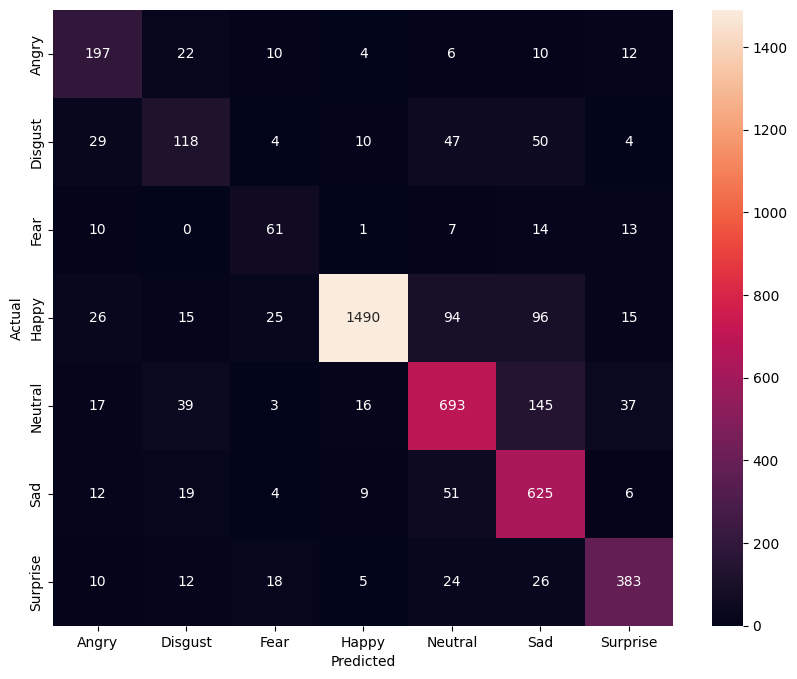

In [100]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_generator)
test_evaluation = model.evaluate(validation_generator)

72/72 [==============================] - 2s 31ms/step - loss: 0.8343 - accuracy: 0.7861


In [102]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions for all validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate top 1 accuracy
top1_accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Top 1 Accuracy: {top1_accuracy:.2f}%")

# Calculate top 2 accuracy
top2_predictions = np.argsort(model.predict(test_img), axis=1)[:, -2:]
top2_accuracy = np.mean([1 if true_label in pred_labels else 0 for true_label, pred_labels in zip(y_true, top2_predictions)]) * 100
print(f"Top 2 Accuracy: {top2_accuracy:.2f}%")

# Calculate loss
loss = model.evaluate(test_img, test_lbl)[0]
print(f"Loss: {loss}")

# Calculate precision
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-Score: {f1:.2f}")


2/2 [==============================] - 0s 45ms/step
Top 1 Accuracy: 78.57%
2/2 [==============================] - 0s 45ms/step
Top 2 Accuracy: 42.19%
2/2 [==============================] - 0s 67ms/step - loss: 0.8164 - accuracy: 0.7969
Loss: 0.8163541555404663
Precision: 0.69
Recall: 0.72
F1-Score: 0.70


# Unseen batch

In [103]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [104]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


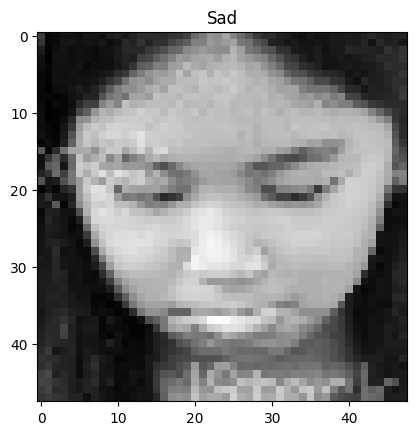

In [105]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Best batch saved
Best batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 42ms/step
Accuracy =  0.734375


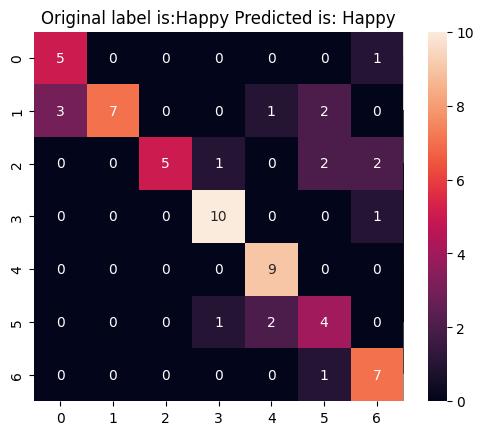

2/2 [==============================] - 0s 43ms/step
Accuracy =  0.4375


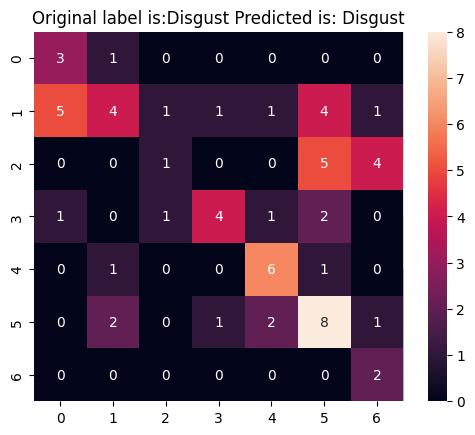

In [106]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [107]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.5396


In [108]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 45ms/step
Accuracy: 53.955078125
Angry 292/2100 acc: 67.1
Disgust 286/2100 acc: 26.2
Fear 293/2100 acc: 22.2
Happy 290/2100 acc: 80.0
Neutral 297/2100 acc: 66.7
Sad 295/2100 acc: 49.5
Surprise 295/2100 acc: 65.4


# Accuracy global and per class

In [109]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 53.955078125
Angry 292/2100 acc: 67.1
Disgust 286/2100 acc: 26.2
Fear 293/2100 acc: 22.2
Happy 290/2100 acc: 80.0
Neutral 297/2100 acc: 66.7
Sad 295/2100 acc: 49.5
Surprise 295/2100 acc: 65.4


              precision    recall  f1-score   support

       Angry       0.56      0.67      0.61       292
     Disgust       0.55      0.26      0.35       286
        Fear       0.56      0.22      0.32       293
       Happy       0.70      0.80      0.75       290
     Neutral       0.56      0.67      0.61       297
         Sad       0.35      0.49      0.41       295
    Surprise       0.57      0.65      0.61       295

    accuracy                           0.54      2048
   macro avg       0.55      0.54      0.52      2048
weighted avg       0.55      0.54      0.52      2048



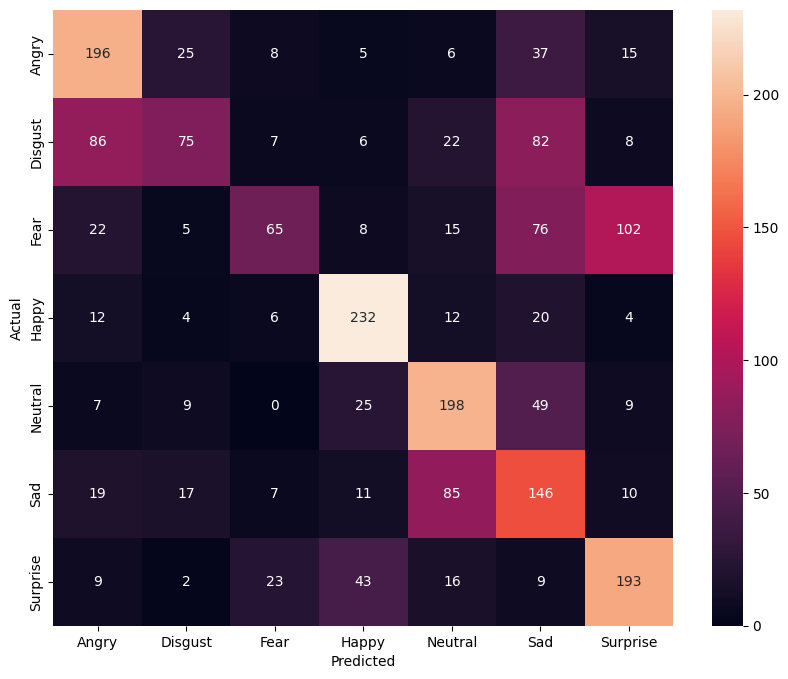

In [110]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with Images

In [27]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
model = load_model('best_model.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Define the background color for the emotion name
    background_color = (255, 255, 255)  # White color

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    text_width, text_height = text_size

    # Adjust the rectangle coordinates to make it larger than the text
    rectangle_x = x
    rectangle_y = y - text_height - 10
    rectangle_width = text_width
    rectangle_height = text_height + 20

    cv2.rectangle(rgb_image, (rectangle_x, rectangle_y), (rectangle_x + rectangle_width, rectangle_y + rectangle_height), background_color, -1)

    # Calculate the position to center the text within the rectangle
    text_x = rectangle_x + (rectangle_width - text_width) // 2
    text_y = rectangle_y + (rectangle_height + text_height) // 2

    cv2.putText(rgb_image, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 1800x1200 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 223ms/step
Predicted emotion class: sad, probability: 0.9176095724105835
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: surprise, probability: 0.9856906533241272
1/1 [==============================] - 0s 20ms/step
Predicted emotion class: fear, probability: 0.9997177720069885
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: sad, probability: 0.5990772843360901
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: happy, probability: 0.9999982118606567
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: angry, probability: 0.9988107681274414
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: disgust, probability: 0.5417860150337219
1/1 [==============================] - 0s 23ms/step
Predicted emotion class: sad, probability: 0.6423495411872864
1/1 [==============================] - 0s 21ms/step
Predicted emotion cla

# Fine Tunning

In [111]:
with strategy.scope():

    model = load_model('best_model.h5')
    
    # # Load the VGG19 model
    # base_model = VGG16(
    #     weights='imagenet', 
    #     include_top=False, 
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the layers
    for layer in model.layers:
        layer.trainable = True
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    # inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # x = base_model(inputs)
    # x = Flatten()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = Dense(128, activation='relu')(x) 
    # predictions = Dense(7, activation='softmax')(x)

    # # Compile the model
    # model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_60 (Conv2D)             (None, 48, 48, 64)   1728        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_60 (BatchN  (None, 48, 48, 64)  256         ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_51 (ReLU)                (None, 48, 48, 64)   0           ['batch_normalization_60[0]

In [112]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [113]:
    # Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=50,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.5021 - accuracy: 0.9095
Epoch 1: val_accuracy improved from -inf to 0.80854, saving model to best_model.h5
167/167 [==============================] - 29s 121ms/step - loss: 0.5021 - accuracy: 0.9095 - val_loss: 0.7033 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.9166
Epoch 2: val_accuracy did not improve from 0.80854
167/167 [==============================] - 18s 105ms/step - loss: 0.4561 - accuracy: 0.9166 - val_loss: 0.7521 - val_accuracy: 0.8028 - lr: 1.0000e-04
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.9143
Epoch 3: val_accuracy did not improve from 0.80854
167/167 [==============================] - 17s 104ms/step - loss: 0.4707 - accuracy: 0.9143 - val_loss: 0.7426 - val_accuracy: 0.8046 - lr: 1.0000e-04
Epoch 4/50
167/167 [==============================] - ETA: 0s - loss: 0.44

In [114]:
save_model = model.save('VGG16_VGGFACE_100e_TF_FT_FER.h5')

In [14]:
model = load_model('VGG16_VGGFACE_100e_TF_FT_FER.h5')

# Fine Tunning model evaluation

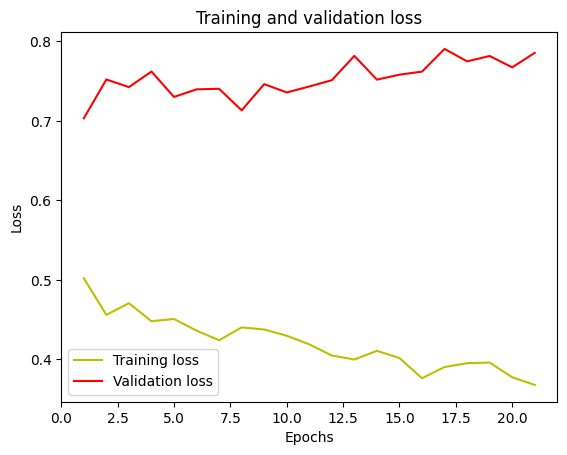

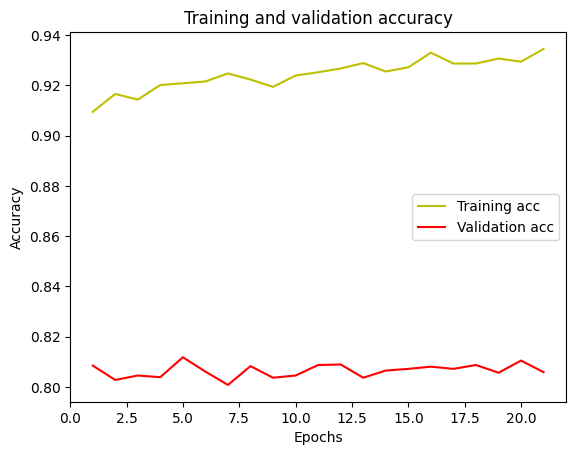

In [115]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 1s 6ms/step
Accuracy =  0.78125


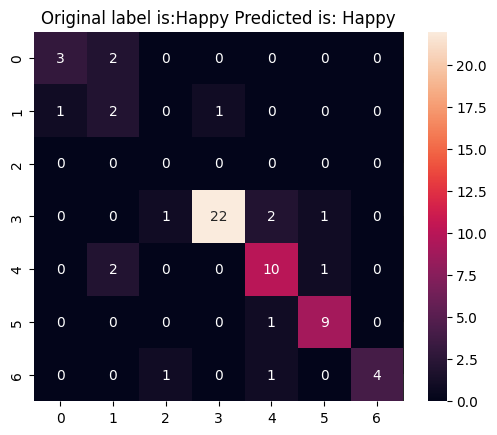

In [15]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Best batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
2/2 [==============================] - 0s 21ms/step
Accuracy =  0.90625


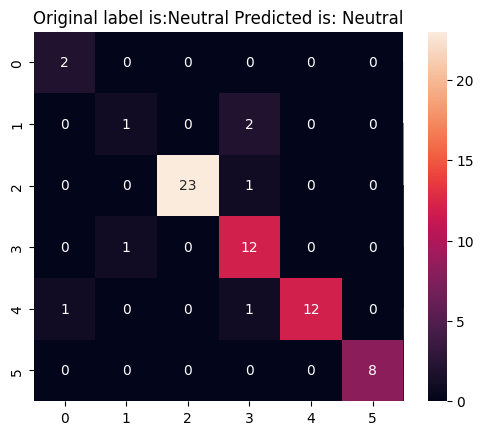

2/2 [==============================] - 0s 20ms/step
Accuracy =  0.734375


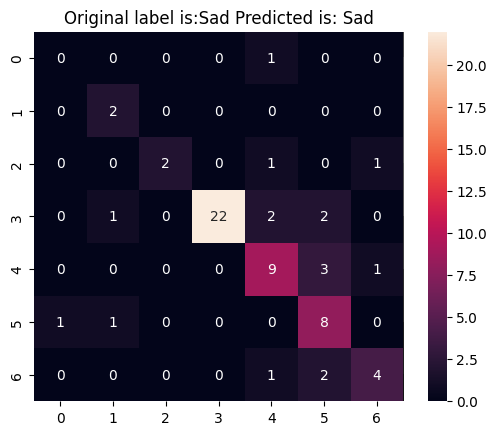

In [16]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [17]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.8066


In [18]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 21ms/step


2/2 [==============================] - 0s 18ms/step
Accuracy: 80.65580985915493
Angry 257/4606 acc: 72.0
Disgust 261/4606 acc: 55.9
Fear 107/4606 acc: 57.0
Happy 1764/4606 acc: 87.9
Neutral 941/4606 acc: 74.0
Sad 731/4606 acc: 86.5
Surprise 483/4606 acc: 81.8


In [19]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 80.65580985915493
Angry 257/4606 acc: 72.0
Disgust 261/4606 acc: 55.9
Fear 107/4606 acc: 57.0
Happy 1764/4606 acc: 87.9
Neutral 941/4606 acc: 74.0
Sad 731/4606 acc: 86.5
Surprise 483/4606 acc: 81.8


              precision    recall  f1-score   support

       Angry       0.73      0.72      0.73       257
     Disgust       0.51      0.56      0.53       261
        Fear       0.54      0.57      0.56       107
       Happy       0.96      0.88      0.92      1764
     Neutral       0.78      0.74      0.76       941
         Sad       0.70      0.86      0.77       731
    Surprise       0.83      0.82      0.82       483

    accuracy                           0.81      4544
   macro avg       0.72      0.74      0.73      4544
weighted avg       0.82      0.81      0.81      4544



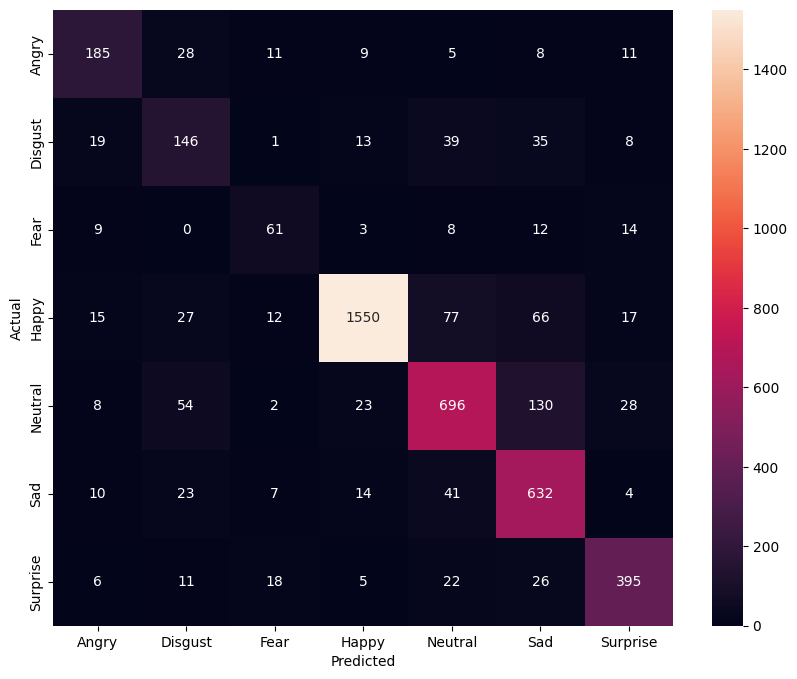

In [20]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen batch

In [ ]:
model = load_model("VGG16_VGGFACE_100e_TF_FT_FER.h5")

In [23]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/JAFFE/Jaffe All/All_converted'

In [24]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 213 images belonging to 7 classes.


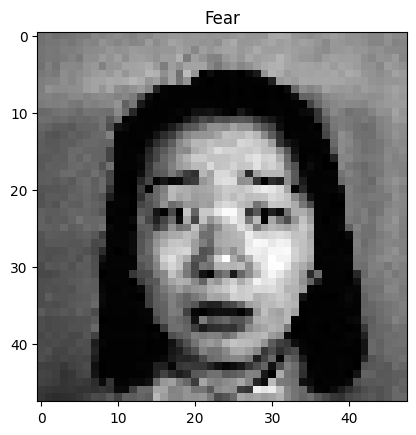

In [25]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Best batch saved
2/2 [==============================] - 0s 17ms/step
Accuracy =  0.28125


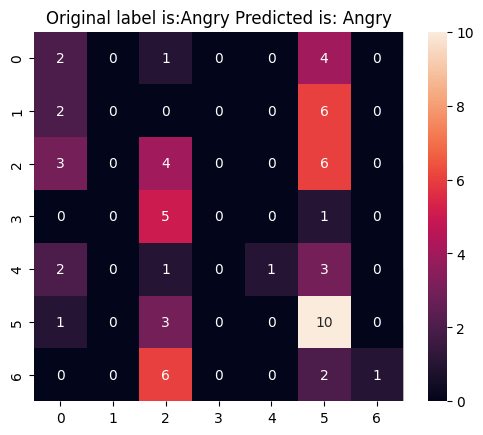

2/2 [==============================] - 0s 16ms/step
Accuracy =  0.1875


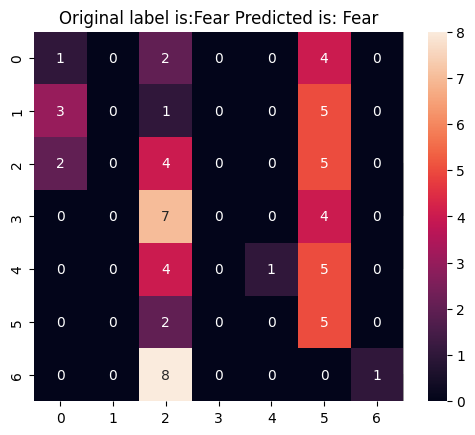

In [34]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [35]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.2240


In [36]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 17ms/step
Accuracy: 22.395833333333336
Angry 25/213 acc: 20.0
Disgust 24/213 acc: 0.0
Fear 31/213 acc: 35.5
Happy 24/213 acc: 0.0
Neutral 29/213 acc: 6.9
Sad 31/213 acc: 74.2
Surprise 28/213 acc: 7.1


# Accuracy global and per class

In [37]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 22.395833333333336
Angry 25/213 acc: 20.0
Disgust 24/213 acc: 0.0
Fear 31/213 acc: 35.5
Happy 24/213 acc: 0.0
Neutral 29/213 acc: 6.9
Sad 31/213 acc: 74.2
Surprise 28/213 acc: 7.1


              precision    recall  f1-score   support

       Angry       0.23      0.20      0.21        25
     Disgust       0.00      0.00      0.00        24
        Fear       0.16      0.35      0.22        31
       Happy       0.00      0.00      0.00        24
     Neutral       1.00      0.07      0.13        29
         Sad       0.24      0.74      0.36        31
    Surprise       1.00      0.07      0.13        28

    accuracy                           0.22       192
   macro avg       0.37      0.21      0.15       192
weighted avg       0.39      0.22      0.16       192



c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

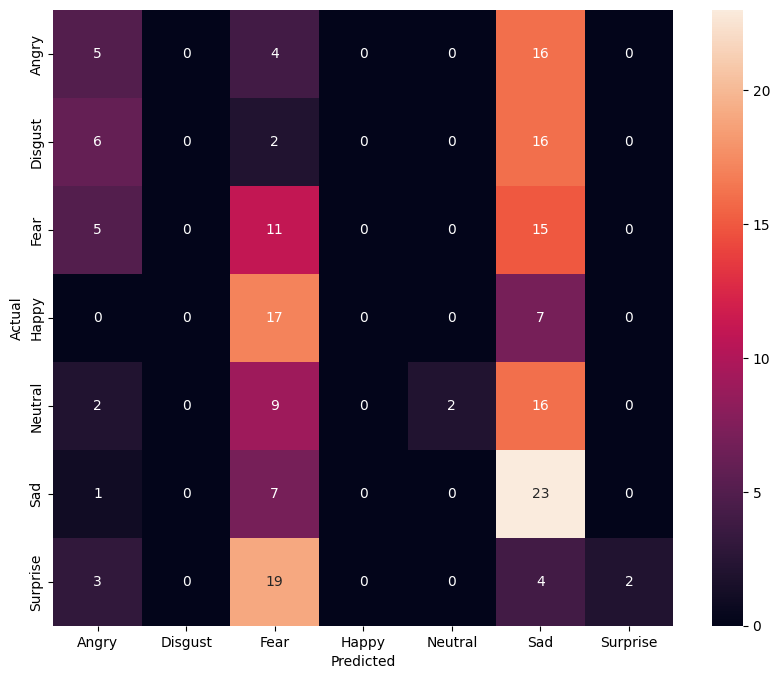

In [38]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

# Load the model
# model = keras.models.load_model('path/to/your/model.h5')

# Set the paths
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/JAFFE/Jaffe All/All_converted'
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'surprised', 'disgusted', 'fearful']

# Use the test generator to get the file paths and labels of the images
file_paths = test_generator.filepaths
labels = test_generator.labels

# Initialize empty lists to store predicted and true labels
predicted_labels = []
true_labels = []

# Iterate through the images
for file_path, label in zip(file_paths, labels):
    # Load and preprocess the image
    image = keras.preprocessing.image.load_img(file_path, target_size=(48, 48))
    image = keras.preprocessing.image.img_to_array(image)
    image /= 255.0
    image = np.expand_dims(image, axis=0)
    
    # Make predictions using the loaded model
    predictions = model.predict(image)
    
    # Get the predicted emotion label
    predicted_label = np.argmax(predictions)
    
    # Append the predicted and true labels to the respective lists
    predicted_labels.append(predicted_label)
    true_labels.append(label)

# Convert the predicted and true labels to NumPy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Generate classification report
classification_rep = classification_report(true_labels, predicted_labels, target_names=emotion_labels, zero_division=1)
print("Classification Report:")
print(classification_rep)


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
Accuracy: 0.20657276995305165
Confusion Matrix:
[[ 6  0  4  0  1 19  0]
 [ 6  0  2  0  0 21  0]
 [ 5  0 11  0  0 16  0]
 [ 0  0 24  0  0  7  0]
 [ 2  1  9  0  2 16  0]
 [ 1  0  7  0  0 23  0]
 [ 3  0 21  0  0  4  2]]
Classification Report:
              precision    recall  f1-score   support

     neutral       0.26      0.20      0.23        30
       happy       0.00      0.00      0.00        29
         sad       0.14      0.34      0.20        32
       angry       1.00      0.00      0.00        31
   surprised       0.67      0.07      0.12        30
   disgusted       0.22      0.74      0.34        31
     fearful       1.00      0.07      0.12        30

    accuracy                           0.21       213
   macro avg       0.47      0.20      0.14       213
weighted avg       0.47      0.21      0.15       213



# Test it with real images

In [45]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
model = load_model('best_model.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/JAFFE/Jaffe All/All_converted/Happy/KA.HA4.32.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 234ms/step
Predicted emotion class: fear, probability: 0.8897548913955688
